# Hate Speech Detection in Indonesian Tweets

In [1]:
# connect to gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [5]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [45]:
df = pd.read_csv('/content/drive/MyDrive/ML/Works/HateSpeech/Dataset/id/[ID-Binary]IDHSD_RIO_unbalanced_713_2017.csv')
df

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...
...,...,...
708,HS,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....
709,HS,"Betul bang hancurkan merka bang, musnahkan chi..."
710,HS,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo..."
711,HS,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar..."


Diketahui bahwa dari dataset tersebut terdapat 2 kolom, Label dan Tweet. Kolom Tweet berisi komentar twitter, sedangkan kolom Label berisi kelas dari tweet. Kelas **Non_HS** menandakan bahwa tweet tersebut bukan termasuk kategori *hate speech*. Kelas **HS** menandakan bahwa tweet tersebut termasuk kategori *hate speech*.

# EDA

## Informasi Data

In [22]:
# Informasi Data
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   713 non-null    object
 1   Tweet   713 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB
None


,Label,Tweet
count,713,713
unique,2,703
top,Non_HS,pertunjukan yang sangat membuat saya serius da...
freq,453,2


In [23]:
# Informasi Duplikat
print('Jumlah Data Duplikat: ', df.duplicated().sum())
df[df.duplicated() == True]

Jumlah Data Duplikat:  10


,Label,Tweet
196,Non_HS,Jadilah orang yang bertanggung jawab atas sega...
198,Non_HS,"Keberagaman itu datang dr hati terdalam, bukan..."
199,Non_HS,Membangun bangsa dan negara ini engga cukup de...
210,Non_HS,jangan ada keberpihakan dalam badan hukum kare...
211,Non_HS,Jika lo bisa menceritakan kembali kalimat2 yg ...
212,Non_HS,"Kenapa debat @MataNajwa ini, Ahok makin keliat..."
219,Non_HS,Kiranya Jakarta semakin baik. Selamat berjuang...
239,Non_HS,pertunjukan yang sangat membuat saya serius da...
270,Non_HS,Seharusnya mah basuki sudah bebas ya kan? #Fre...
625,HS,"Sini lu, kami enggak mau kampung kami didatang..."


In [27]:
# Informasi Missing Value
print('Jumlah Data Kosong:\n',df.isna().sum())

Jumlah Data Kosong:
 Label    0
Tweet    0
dtype: int64


## Distribusi Kelas

Hate Speech
Jumlah:  260
Persentase:  36.4656381486676
Non Hate Speech
Jumlah:  453
Persentase:  63.5343618513324




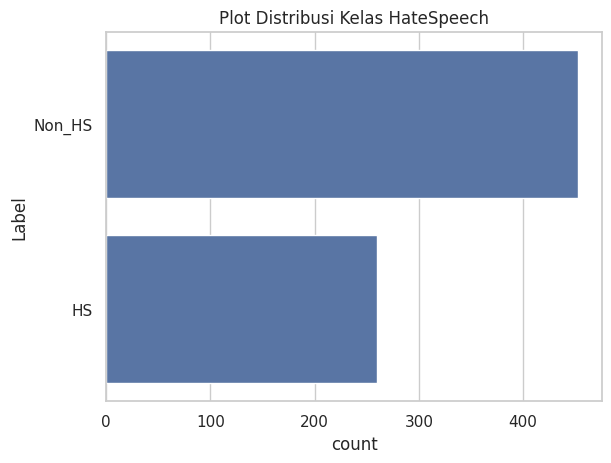

In [16]:
n_Non_HS = df[df['Label']=='Non_HS']['Label'].count()
n_HS = df[df['Label']=='HS']['Label'].count()
percent_Non_HS = (n_Non_HS/(n_Non_HS+n_HS)*100)
percent_HS= (n_HS/(n_Non_HS+n_HS))*100

print('Hate Speech')
print('Jumlah: ', n_HS)
print('Persentase: ', percent_HS)
print('===============')
print('Non Hate Speech')
print('Jumlah: ', n_Non_HS)
print('Persentase: ', percent_Non_HS)
print('\n')
sns.countplot(df['Label'])
plt.title('Plot Distribusi Kelas HateSpeech')
plt.show()

## Distribusi Karakter

Persebaran Karakter Dalam Tweet


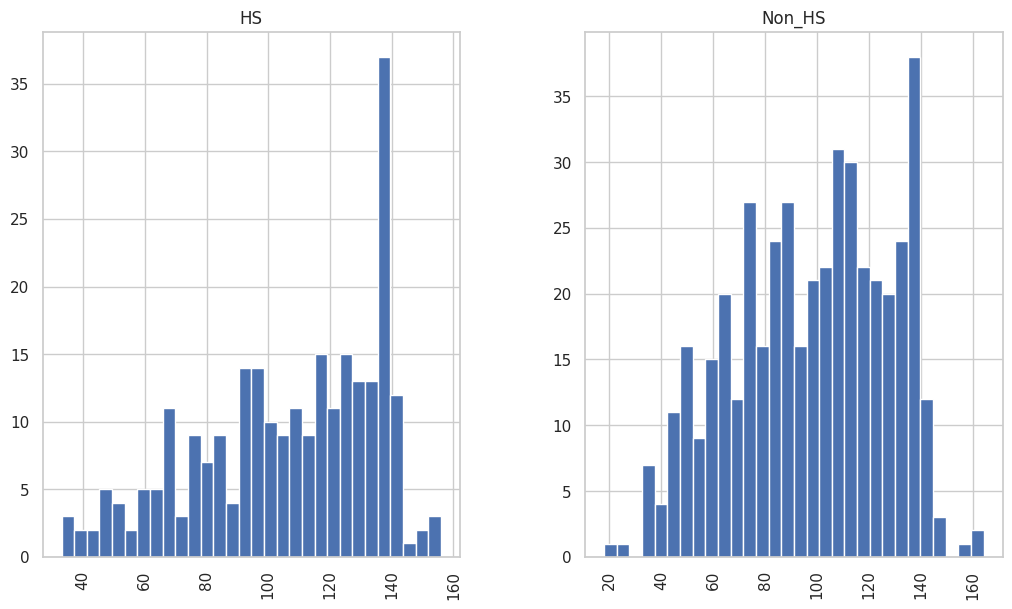

In [46]:
df['char_length'] = df['Tweet'].apply(len)
df.hist(column='char_length', by='Label', bins=30, figsize=(12,7))
print('Persebaran Karakter Dalam Tweet')
plt.show()

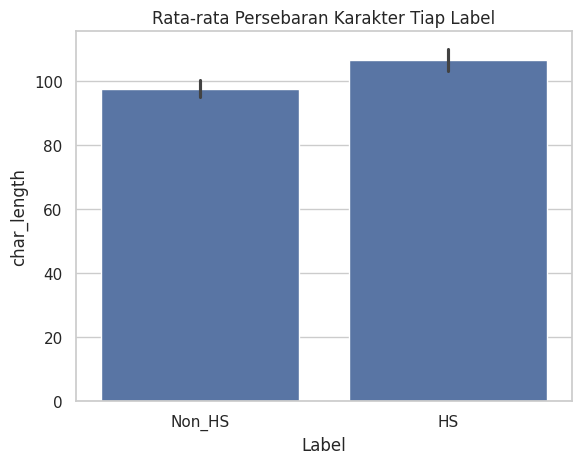

In [47]:
fig1 = sns.barplot(x='Label',y='char_length',data = df)
plt.title('Rata-rata Persebaran Karakter Tiap Label')
plot = fig1.get_figure()
plt.show()

# Preprocessing

## Drop Duplicates

In [48]:
print('Jumlah Awal Data: ', df.shape[0])
df.drop_duplicates(inplace=True)
print('Jumlah Setelah Bebas Duplikat: ', df.shape[0])

Jumlah Awal Data:  713
Jumlah Setelah Bebas Duplikat:  703


In [49]:
pre_df = df.copy()

## Tweet Cleaning
Pada pembersihan tweet akan dilakukan penghilangan mention (@), penghilangan link, penghapusan new line, penghapusan kata RT, penghapusan angka dan tanda baca, penghapusan whitespace, dan konversi ke lowercase

In [50]:
import re

def clean_tweet(data):
  temp_tweet = []
  for tweet in data:
    # removal of @name[mention]
    tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
    # removal of links[https://blabala.com]
    tweet = re.sub(r"http\S+", "", tweet)
    # removal of new line
    tweet = re.sub('\n', '', tweet)
    # removal of RT
    tweet = re.sub('RT', '', tweet)
    # removal of punctuations and numbers
    tweet = re.sub("[^a-zA-Z^']", " ", tweet)
    tweet = re.sub(" {2,}", " ", tweet)
    # remove leading and trailing whitespace
    tweet = tweet.strip()
    # remove whitespace with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    # convert text to Lowercase
    tweet = tweet.lower();
    temp_tweet.append(tweet)
  return temp_tweet

In [51]:
pre_df['cleaned_tweet']=clean_tweet(pre_df['Tweet'])
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada


## Tokenization

In [52]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [53]:
def tokenized(data):
  return data.apply(nltk.word_tokenize)

In [54]:
pre_df['tokenized']=tokenized(pre_df['cleaned_tweet'])
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]"


## Stemming

In [55]:
!pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


In [56]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [57]:
def stemming(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return [stemmer.stem(tweet) for tweet in data]

In [58]:
pre_df['stemmed'] = pre_df['tokenized'].apply(stemming)
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized,stemmed
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, minta, mendagri, segera, nonaktif..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[mereka, terus, luka, aksi, dalam, rangka, pen..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]","[waspada, ktp, palsu, kawal, pilkada]"


## Slangword Removal

In [59]:
import requests

slang_word = requests.get('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt').text
dict_slang = eval(slang_word)

In [60]:
dict_slang.items()

dict_items([('@', 'di'), ('abis', 'habis'), ('ad', 'ada'), ('adlh', 'adalah'), ('afaik', 'as far as i know'), ('ahaha', 'haha'), ('aj', 'saja'), ('ajep-ajep', 'dunia gemerlap'), ('ak', 'saya'), ('akika', 'aku'), ('akkoh', 'aku'), ('akuwh', 'aku'), ('alay', 'norak'), ('alow', 'halo'), ('ambilin', 'ambilkan'), ('ancur', 'hancur'), ('anjrit', 'anjing'), ('anter', 'antar'), ('ap2', 'apa-apa'), ('apasih', 'apa sih'), ('apes', 'sial'), ('aps', 'apa'), ('aq', 'saya'), ('aquwh', 'aku'), ('asbun', 'asal bunyi'), ('aseekk', 'asyik'), ('asekk', 'asyik'), ('asem', 'asam'), ('aspal', 'asli tetapi palsu'), ('astul', 'asal tulis'), ('ato', 'atau'), ('au ah', 'tidak mau tahu'), ('awak', 'saya'), ('ay', 'sayang'), ('ayank', 'sayang'), ('b4', 'sebelum'), ('bakalan', 'akan'), ('bandes', 'bantuan desa'), ('bangedh', 'banget'), ('banpol', 'bantuan polisi'), ('banpur', 'bantuan tempur'), ('basbang', 'basi'), ('bcanda', 'bercanda'), ('bdg', 'bandung'), ('begajulan', 'nakal'), ('beliin', 'belikan'), ('bencong

In [61]:
slang_df = pd.DataFrame(dict_slang.items(), columns=['Old', 'New'])
slang_df.head()

,Old,New
0,@,di
1,abis,habis
2,ad,ada
3,adlh,adalah
4,afaik,as far as i know


In [62]:
# remove trailing white space
slang_df['Old'] = slang_df['Old'].apply(lambda x: x.strip())
slang_df['New'] = slang_df['New'].apply(lambda x: x.strip())

In [63]:
# transform into key value in a dict
slang_dict = {}
for i, row in slang_df.iterrows():
  slang_dict.update({row['Old']: row['New']})

In [64]:
def removeSlang(data):
  for i, word in enumerate(data):
    # check if data in slang dictionary or not
    try:
      data[i] = slang_dict[word]
    # if data is not slang then pass
    except KeyError:
      pass
  return data

In [65]:
pre_df['unslang'] = pre_df['stemmed'].apply(removeSlang)
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized,stemmed,unslang
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, minta, mendagri, segera, nonaktif..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[mereka, terus, luka, aksi, dalam, rangka, pen..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, tidak, puas, debat, pemilihan k..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ..."


## Stopword Removal

In [66]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [67]:
def removeStopWords(data):
  stop_words = set(stopwords.words('indonesian'))
  return data.apply(lambda x: [item for item in x if item not in stop_words])

In [68]:
pre_df['freestop']=removeStopWords(pre_df['unslang'])
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized,stemmed,unslang,freestop
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, mendagri, nonaktif, ahok, gubernu..."
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk..."
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, puas, debat, pemilihan kepala d..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ..."


## Label Encoding

In [69]:
pre_df['Label'] = pre_df['Label'].apply(lambda x: 1 if x == 'HS' else 0)
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized,stemmed,unslang,freestop
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, mendagri, nonaktif, ahok, gubernu..."
1,0,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk..."
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, puas, debat, pemilihan kepala d..."
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ..."


## Ready Data

In [70]:
# combine cleaned text after removing stop words into one string
pre_df['ready'] = pre_df['freestop'].apply(lambda x: ' '.join(x))
pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized,stemmed,unslang,freestop,ready
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, mendagri, nonaktif, ahok, gubernu...",fadli zon mendagri nonaktif ahok gubernur dki
1,0,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[luka, aksi, rangka, penjara, ahok, ahok, gaga...",luka aksi rangka penjara ahok ahok gagal pemil...
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk...",sylvi gurbernur laku keras perempuan bukti fot...
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, puas, debat, pemilihan kepala d...",ahmad dhani puas debat pemilihan kepala daerah...
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ...",waspada ktp palsu kawal pemilihan kepala daerah


In [72]:
data1 = pre_df[['ready']]
data2 = pre_df[['Label']]
dataset = pd.concat([data1, data2], axis=1)
dataset = dataset.rename(columns={'ready': 'tweet', 'Label': 'label'})
dataset.head()

,tweet,label
0,fadli zon mendagri nonaktif ahok gubernur dki,0
1,luka aksi rangka penjara ahok ahok gagal pemil...,0
2,sylvi gurbernur laku keras perempuan bukti fot...,0
3,ahmad dhani puas debat pemilihan kepala daerah...,0
4,waspada ktp palsu kawal pemilihan kepala daerah,0


# Feature Extraction

## Text Vectorization (TF-IDF)

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
X = dataset['tweet']
y = dataset['label']

In [75]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vector = tfidf_vectorizer.fit_transform(X)
tfidf_vector.shape

(703, 1951)

## Handle Imbalance

In [78]:
from imblearn.over_sampling import SMOTE

In [79]:
sampler = SMOTE()
tfidf_vector, y = sampler.fit_resample(tfidf_vector, y)
print(tfidf_vector.shape)
print(y.shape)

(888, 1951)
(888,)


## Data Splitting

In [76]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vector, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(710, 1951)
(178, 1951)
(710,)
(178,)


## Common vs Important Words

In [81]:
feature_names = np.array(tfidf_vectorizer.get_feature_names())

# Sort TFIDF by value
max_tf_idfs = X_train.max(0).toarray()[0] # Get largest tfidf values across all documents.
sorted_tf_idxs = max_tf_idfs.argsort() # Sorted indices
sorted_tf_idfs = max_tf_idfs[sorted_tf_idxs] # Sorted TFIDF values

# feature_names doesn't need to be sorted! You just access it with a list of sorted indices!
smallest_tf_idfs = pd.Series(sorted_tf_idfs[:10], index=feature_names[sorted_tf_idxs[:10]])
largest_tf_idfs = pd.Series(sorted_tf_idfs[-10:][::-1], index=feature_names[sorted_tf_idxs[-10:][::-1]])

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

## WordCloud

In [82]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

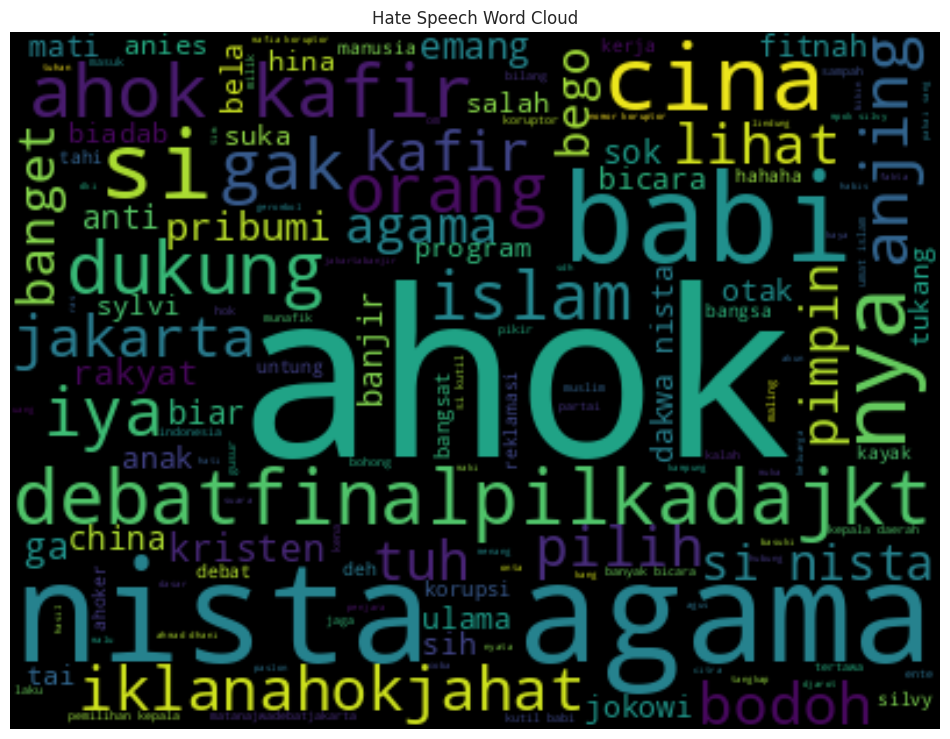

In [86]:
# Hate Speech Word
hs_words = ' '.join([word for word in dataset['tweet'][dataset['label']==1]])
wordcloud = WordCloud(width=400, height=300, max_font_size=100).generate(hs_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Speech Word Cloud')
plt.axis('off')
plt.show()

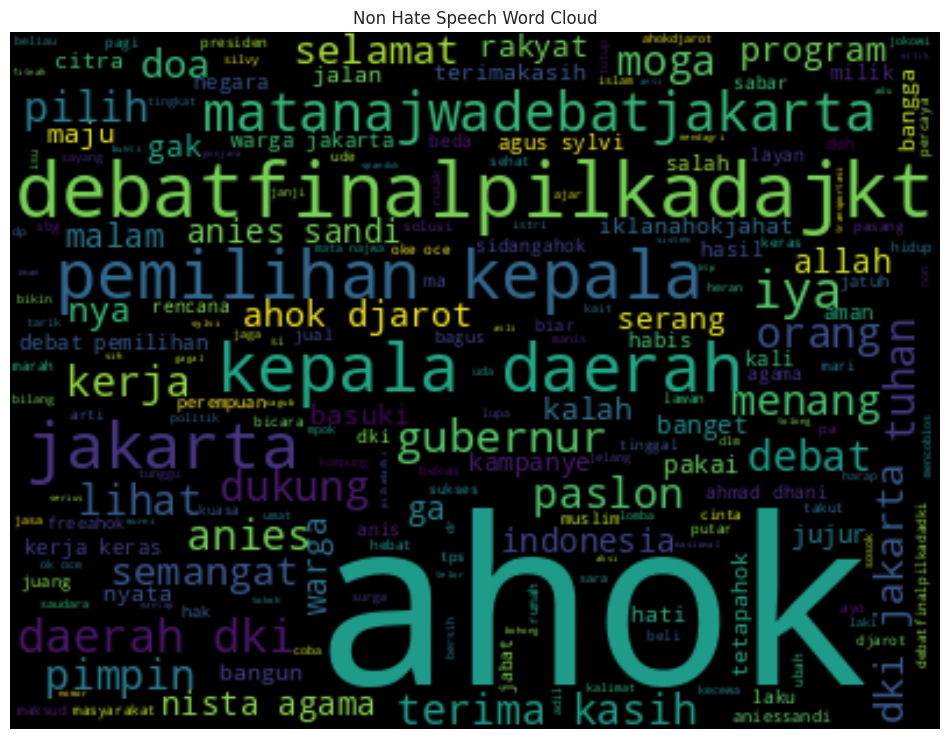

In [87]:
# Non Hate Speech Word
nhs_words = ' '.join([word for word in dataset['tweet'][dataset['label']==0]])
wordcloud = WordCloud(width=400, height=300, max_font_size=100).generate(nhs_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Non Hate Speech Word Cloud')
plt.axis('off')
plt.show()

# Modeling

In [88]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

In [89]:
# function to print confusion matrix
def print_conf(y_test, result, classes, title='Confusion matrix'):
  conf_matrix = metrics.confusion_matrix(y_test, result)
  plt.figure(figsize=(6,6))
  sns.heatmap(conf_matrix,
              annot=True,
              xticklabels=classes,
              yticklabels=classes,
              cmap="Blues",
              fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title(title)
  plt.show()

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# function to get full metrics score
def getFullScore(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  # Calculate precision
  precision = precision_score(y_test, y_pred)
  # Calculate recall
  recall = recall_score(y_test, y_pred)
  # Calculate F1 score
  f1 = f1_score(y_test, y_pred)
  return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score':f1}

## SVM

In [91]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

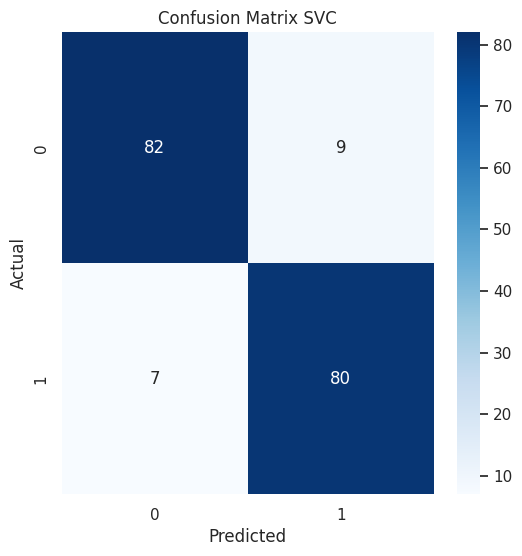

In [94]:
print_conf(y_test, y_pred_svc, [0, 1], title="Confusion Matrix SVC")

In [95]:
print(metrics.classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        91
           1       0.90      0.92      0.91        87

    accuracy                           0.91       178
   macro avg       0.91      0.91      0.91       178
weighted avg       0.91      0.91      0.91       178



In [103]:
print('SVM Score')
getFullScore(y_test, y_pred_svc)

SVM Score


{'Accuracy': 0.9101123595505618,
 'Precision': 0.898876404494382,
 'Recall': 0.9195402298850575,
 'F1-Score': 0.9090909090909091}

## Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
log_reg = LogisticRegression()
# Train the model
log_reg.fit(X_train, y_train)
# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)

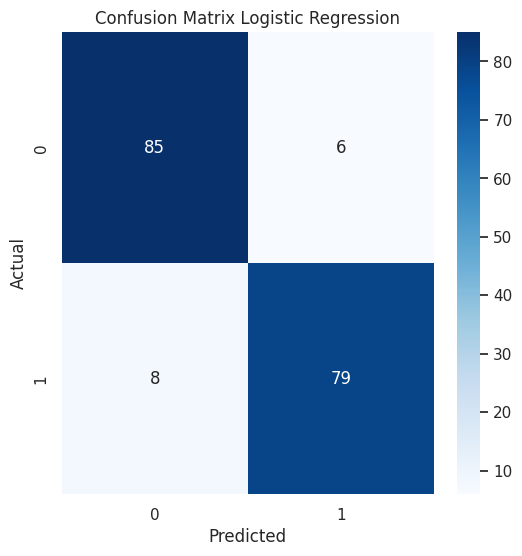

In [122]:
print_conf(y_test, y_pred_log_reg, [0, 1], title="Confusion Matrix Logistic Regression")

In [123]:
print(metrics.classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        91
           1       0.93      0.91      0.92        87

    accuracy                           0.92       178
   macro avg       0.92      0.92      0.92       178
weighted avg       0.92      0.92      0.92       178



In [124]:
print('Logistic Regression Score')
getFullScore(y_test, y_pred_log_reg)

Logistic Regression Score


{'Accuracy': 0.9213483146067416,
 'Precision': 0.9294117647058824,
 'Recall': 0.9080459770114943,
 'F1-Score': 0.9186046511627908}

## Decision Tree

In [108]:
from sklearn.tree import DecisionTreeClassifier
# Initialize Decision Tree classifier
decision_tree = DecisionTreeClassifier()
# Train the model
decision_tree.fit(X_train, y_train)
# Predict on the test set
y_pred_decision_tree = decision_tree.predict(X_test)

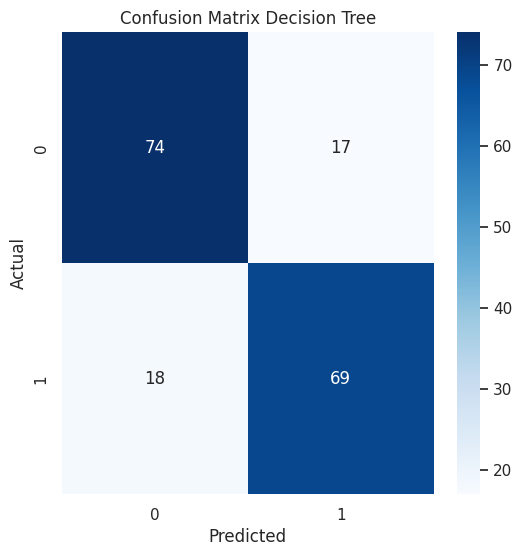

In [109]:
print_conf(y_test, y_pred_decision_tree, [0, 1], title="Confusion Matrix Decision Tree")

In [110]:
print(metrics.classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81        91
           1       0.80      0.79      0.80        87

    accuracy                           0.80       178
   macro avg       0.80      0.80      0.80       178
weighted avg       0.80      0.80      0.80       178



In [111]:
print('Decision Tree Score')
getFullScore(y_test, y_pred_decision_tree)

Decision Tree Score


{'Accuracy': 0.8033707865168539,
 'Precision': 0.8023255813953488,
 'Recall': 0.7931034482758621,
 'F1-Score': 0.7976878612716762}

## XGBoost

In [112]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier()
# Train the model
xgb_classifier.fit(X_train, y_train)
# Predict on the test set
y_pred_xgb = xgb_classifier.predict(X_test)

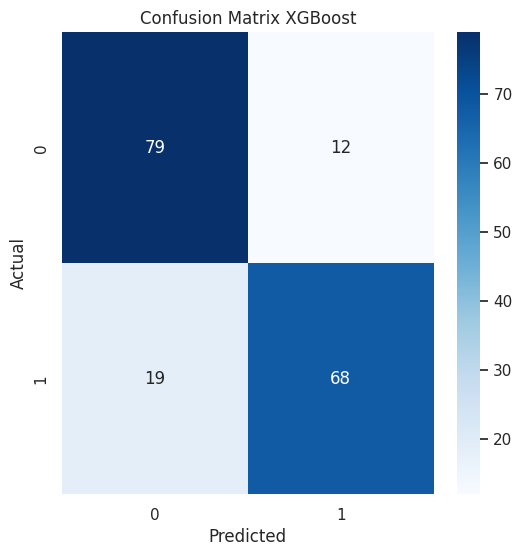

In [113]:
print_conf(y_test, y_pred_xgb, [0, 1], title="Confusion Matrix XGBoost")

In [114]:
print(metrics.classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        91
           1       0.85      0.78      0.81        87

    accuracy                           0.83       178
   macro avg       0.83      0.82      0.83       178
weighted avg       0.83      0.83      0.83       178



In [116]:
print('XGB Score')
getFullScore(y_test, y_pred_xgb)

XGB Score


{'Accuracy': 0.8258426966292135,
 'Precision': 0.85,
 'Recall': 0.7816091954022989,
 'F1-Score': 0.8143712574850299}

## Random Forest

In [117]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier
random_forest = RandomForestClassifier()
# Train the model
random_forest.fit(X_train, y_train)
# Predict on the test set
y_pred_random_forest = random_forest.predict(X_test)

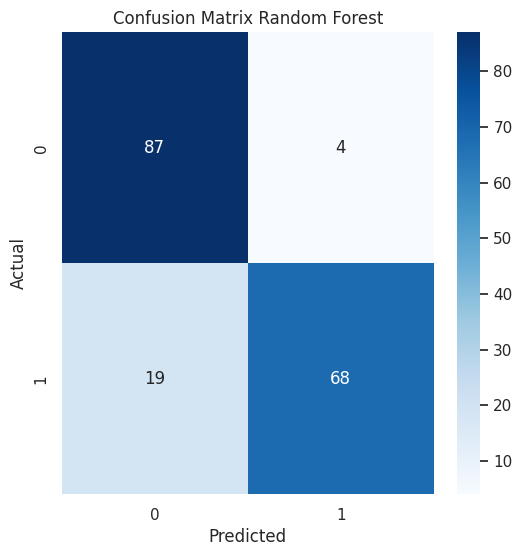

In [118]:
print_conf(y_test, y_pred_random_forest, [0, 1], title="Confusion Matrix Random Forest")

In [119]:
print(metrics.classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88        91
           1       0.94      0.78      0.86        87

    accuracy                           0.87       178
   macro avg       0.88      0.87      0.87       178
weighted avg       0.88      0.87      0.87       178



In [120]:
print('Random Forest Score')
getFullScore(y_test, y_pred_random_forest)

Random Forest Score


{'Accuracy': 0.8707865168539326,
 'Precision': 0.9444444444444444,
 'Recall': 0.7816091954022989,
 'F1-Score': 0.8553459119496855}

# Model Comparison

In [125]:
# Accuracy Comparison
models = ['SVM', 'Logistic Regression', 'Decision Tree','XGBoost', 'Random Forest']
accSVMC = metrics.accuracy_score(y_test,y_pred_svc)
accLR = metrics.accuracy_score(y_test, y_pred_log_reg)
accDT = metrics.accuracy_score(y_test, y_pred_decision_tree)
accXGB = metrics.accuracy_score(y_test, y_pred_xgb)
accRF = metrics.accuracy_score(y_test, y_pred_random_forest)

accuracies = [accSVMC, accLR, accDT, accXGB, accRF]
comp = pd.DataFrame(list(zip(models, accuracies)), columns=['Model', 'Accuracy'])
comp

,Model,Accuracy
0,SVM,0.910112
1,Logistic Regression,0.921348
2,Decision Tree,0.803371
3,XGBoost,0.825843
4,Random Forest,0.870787


## Saving Model

## Joblib

In [127]:
import joblib

# Saving Vectorizer
joblib.dump(tfidf_vectorizer, 'Hate-Speech-TFIDF.joblib')

# Saving model SVC
joblib.dump(svc, '[SVM]Hate-Speech-Classifier.joblib')
# Saving model Logistic Regression
joblib.dump(log_reg, '[LR]Hate-Speech-Classifier.joblib')
# Saving model Random Forest
joblib.dump(random_forest, '[RF]Hate-Speech-Classifier.joblib')

['[RF]Hate-Speech-Classifier.joblib']

## Pickle

In [128]:
import pickle

# Saving Vectorizer
with open('Hate-Speech-TFIDF.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Saving model SVC
with open('[SVM]Hate-Speech-Classifier.pkl', 'wb') as f:
    pickle.dump(svc, f)

# Saving model Logistic Regression
with open('[LR]Hate-Speech-Classifier.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

# Saving model Random Forest
with open('[RF]Hate-Speech-Classifier.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

## Saving Prediction Dataframe

In [132]:
pre_df['prediction'] = log_reg.predict(tfidf_vectorizer.transform(pre_df['ready']))
pre_df['prediction'] = pre_df['prediction'].apply(lambda x: 'HS' if x==1 else 'Non_HS')

# Save new dataframe into csv file
pre_df.to_csv('Hate Speech Classification.csv', index=False)

pre_df.head()

,Label,Tweet,char_length,cleaned_tweet,tokenized,stemmed,unslang,freestop,ready,prediction
0,0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,110,fadli zon minta mendagri segera menonaktifkan ...,"[fadli, zon, minta, mendagri, segera, menonakt...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, minta, mendagri, segera, nonaktif...","[fadli, zon, mendagri, nonaktif, ahok, gubernu...",fadli zon mendagri nonaktif ahok gubernur dki,Non_HS
1,0,RT @baguscondromowo: Mereka terus melukai aksi...,108,mereka terus melukai aksi dalam rangka memenja...,"[mereka, terus, melukai, aksi, dalam, rangka, ...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[mereka, terus, luka, aksi, dalam, rangka, pen...","[luka, aksi, rangka, penjara, ahok, ahok, gaga...",luka aksi rangka penjara ahok ahok gagal pemil...,Non_HS
2,0,Sylvi: bagaimana gurbernur melakukan kekerasan...,116,sylvi bagaimana gurbernur melakukan kekerasan ...,"[sylvi, bagaimana, gurbernur, melakukan, keker...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, bagaimana, gurbernur, laku, keras, per...","[sylvi, gurbernur, laku, keras, perempuan, buk...",sylvi gurbernur laku keras perempuan bukti fot...,Non_HS
3,0,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",115,ahmad dhani tak puas debat pilkada masalah jal...,"[ahmad, dhani, tak, puas, debat, pilkada, masa...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, tidak, puas, debat, pemilihan k...","[ahmad, dhani, puas, debat, pemilihan kepala d...",ahmad dhani puas debat pemilihan kepala daerah...,Non_HS
4,0,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,79,waspada ktp palsu kawal pilkada,"[waspada, ktp, palsu, kawal, pilkada]","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ...","[waspada, ktp, palsu, kawal, pemilihan kepala ...",waspada ktp palsu kawal pemilihan kepala daerah,Non_HS


## Predict New Data

In [133]:
input_tweet = ['dasar cina',
               'terima kasih KPU pilkada berjalan lancar mantap djiwa njir']

def preProcessText(tweets):
    new_tweets = []
    for tw in tweets:
        tw = clean_tweet(tw)
        tw = tokenized(tw)
        tw = stemming(tw)
        tw = removeSlang(tw)
        tw = removeStopWords(tw)
        tw = ' '.join(tw)
        new_tweets.append(tw)

    return new_tweets

def predictNewData(tweets):
    saved_model = joblib.load('/content/[LR]Hate-Speech-Classifier.joblib')
    saved_tfidf = joblib.load('/content/Hate-Speech-TFIDF.joblib')

    vectorized_tweets = saved_tfidf.transform(tweets)
    input_prediction = saved_model.predict(vectorized_tweets)

    for i in range(len(input_tweet)):
        if input_prediction[i]==1:
            print('Input text:\n',
                input_tweet[i],
                '\nPrediction: \nHate Speech!\n')
        else:
            print('Input text:\n',
                input_tweet[i],
                "\nPrediction: \nNot a Hate Speech.\n")

predictNewData(input_tweet)

Input text:
 dasar cina 
Prediction: 
Hate Speech!

Input text:
 terima kasih KPU pilkada berjalan lancar mantap djiwa njir 
Prediction: 
Not a Hate Speech.

